In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, Multiply, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import torch

2025-12-22 11:41:05.301999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def clean_and_interpolate_with_mask(data):
    """
    Simplified version with binary confidence:
    - 1.0: Successfully interpolated (or originally valid)
    - 0.0: Zero-filled (ALPE must handle)
    """
    df = pd.DataFrame(data).astype(np.float32)
    original_missing_mask = df.isnull()  # True = missing, False = valid
    
    print(f"Originally missing values: {original_missing_mask.sum().sum()}")

    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1)
    df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
    
    still_missing = df_filled.isnull()  # These will become zeros
    
    print(f"Still missing after all interpolation: {still_missing.sum().sum()}")
    
    # Fill remaining with zeros
    df_final = df_filled.fillna(0)
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    
    # binary mask
    confidence_mask = np.ones_like(df_interpolated_fin.values, dtype=np.float32)
    
    # Only mark as 0.0 where we had to use fillna(0)
    confidence_mask[still_missing.values] = 0.0
    # Everything else (originally valid OR successfully interpolated) = 1.0
    
    result = df_interpolated_fin.values
    mask = confidence_mask
    
    return result, mask

In [4]:
class ALPELayer(Layer):
    """
    Attention-based Learnable Positional Encoding as a custom Keras Layer
    """
    def __init__(self, n_timesteps=24, embed_dim=64, dropout_rate=0.5, name='alpe', **kwargs):
        super(ALPELayer, self).__init__(name=name, **kwargs)
        self.n_timesteps = n_timesteps
        self.embed_dim = embed_dim
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        """
        Build layer components
        input_shape: tuple of (x_shape, mask_shape)
        """
        feature_dim = input_shape[0][-1]  # Get feature dimension from x
        
        # Positional embedding layer
        self.pos_embedding = Embedding(
            input_dim=self.n_timesteps,
            output_dim=self.embed_dim,
            name=f'{self.name}_pos_embed')
        
        # 1D Convolution for learning interpolation patterns
        self.conv1d = Conv1D(
            filters=self.embed_dim,
            kernel_size=3,
            padding='same',
            activation='relu',
            name=f'{self.name}_conv1d')
        
        # ECA: Adaptive kernel size
        k_size = max(3, int(abs((np.log2(self.embed_dim) + 1) / 2)))
        if k_size % 2 == 0:
            k_size += 1
        
        # ECA channel attention
        self.eca_conv = Conv1D(
            filters=1,
            kernel_size=k_size,
            padding='same',
            activation='sigmoid',
            name=f'{self.name}_eca')
        
        # Projection to match input feature dimension
        if self.embed_dim != feature_dim:
            self.projection = Dense(
                units=feature_dim,
                name=f'{self.name}_projection')
        else:
            self.projection = None

        # Add dropout layer
        self.dropout = Dropout(self.dropout_rate, name=f'{self.name}_dropout')
        
        # Store feature_dim for rebuild
        self.feature_dim = feature_dim
        
        # CRITICAL: Actually build the sub-layers
        self.pos_embedding.build((None,))  # Embedding input shape
        self.conv1d.build((None, self.n_timesteps, self.embed_dim))
        
        k_size = max(3, int(abs((np.log2(self.embed_dim) + 1) / 2)))
        if k_size % 2 == 0:
            k_size += 1
        self.eca_conv.build((None, 1, self.embed_dim))
        
        if self.projection is not None:
            self.projection.build((None, self.n_timesteps, self.embed_dim))
        
        self.dropout.build((None, self.n_timesteps, feature_dim))
        
        super(ALPELayer, self).build(input_shape)
    
    def call(self, inputs, training=None):
        """
        Forward pass
        inputs: [x, confidence_mask]
            x: [batch, timesteps, features]
            confidence_mask: [batch, timesteps]
        """
        x, confidence_mask = inputs
        
        # ============================================================
        # STEP 1: Create positional embeddings
        # ============================================================
        position_ids = tf.range(self.n_timesteps)
        pos_embedding = self.pos_embedding(position_ids)  # [timesteps, embed_dim]
        
        # Broadcast to batch dimension
        batch_size = tf.shape(x)[0]
        pos_embedding = tf.tile(
            tf.expand_dims(pos_embedding, axis=0),
            [batch_size, 1, 1]
        )  # [batch, timesteps, embed_dim]
        
        # Apply conf mask
        mask_expanded = tf.expand_dims(confidence_mask, axis=-1)  # [batch, timesteps, 1]
        mask_expanded = tf.cast(mask_expanded, tf.float32)
        
        # Invert mask: confidence=1.0 → weight=0.0, confidence=0.0 → weight=1.0
        alpe_weight = 1.0 - mask_expanded  # [batch, timesteps, 1]
        
        # Apply weight to positional encoding
        masked_pe = pos_embedding * alpe_weight  # [batch, timesteps, embed_dim]

        # Keras Conv1D expects [batch, timesteps, channels]
        # masked_pe is already in correct shape: [batch, timesteps, embed_dim]
        pe_conv = self.conv1d(masked_pe)  # [batch, timesteps, embed_dim]
        
        # For ECA on channels, we need to work on channel dimension
        # Transpose to [batch, embed_dim, timesteps] for channel-wise operations
        pe_transposed = tf.transpose(pe_conv, perm=[0, 2, 1])  # [batch, embed_dim, timesteps]
        
        # Global average pooling across time
        gap = tf.reduce_mean(pe_transposed, axis=-1, keepdims=True)  # [batch, embed_dim, 1]
        
        # Reshape for Conv1D: [batch, embed_dim, 1] → need [batch, timesteps=embed_dim, channels=1]
        gap_reshaped = tf.transpose(gap, perm=[0, 2, 1])  # [batch, 1, embed_dim]
        
        # Channel attention via 1D conv
        channel_att = self.eca_conv(gap_reshaped)  # [batch, 1, embed_dim]
        
        # Reshape back: [batch, 1, embed_dim] → [batch, embed_dim, 1]
        channel_att = tf.transpose(channel_att, perm=[0, 2, 1])  # [batch, embed_dim, 1]
        
        # Apply attention to pe_transposed [batch, embed_dim, timesteps]
        pe_attended = pe_transposed * channel_att  # [batch, embed_dim, timesteps]
        
        # ============================================================
        # STEP 5: Transpose back to [batch, timesteps, embed_dim]
        # ============================================================
        alpe_output = tf.transpose(pe_attended, perm=[0, 2, 1])  # [batch, timesteps, embed_dim]
        
        # Project to match input feature dimension if needed
        if self.projection is not None:
            alpe_output = self.projection(alpe_output)  # [batch, timesteps, features]

        alpe_output = self.dropout(alpe_output, training=training)
        
        # ============================================================
        # STEP 6: Residual connection with weighting
        # ============================================================
        # Now shapes match:
        # alpe_output: [batch, timesteps, features]
        # alpe_weight: [batch, timesteps, 1]
        alpe_contribution = alpe_output * alpe_weight  # Broadcasting works!
        x_enhanced = x + alpe_contribution
        
        return x_enhanced
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]  # Return x's shape
    
    def get_config(self):
        config = super(ALPELayer, self).get_config()
        config.update({
            'n_timesteps': self.n_timesteps,
            'embed_dim': self.embed_dim,
            'dropout_rate': self.dropout_rate
        })
        return config
    
    def get_build_config(self):
        """Return configuration needed to rebuild the layer during loading"""
        build_config = {
            'feature_dim': getattr(self, 'feature_dim', None)
        }
        return build_config
    
    def build_from_config(self, config):
        """Rebuild the layer's internal state from config"""
        feature_dim = config.get('feature_dim')
        if feature_dim is not None:
            # Reconstruct input_shape that build() expects
            input_shape = (
                (None, self.n_timesteps, feature_dim),  # x_shape
                (None, self.n_timesteps)  # mask_shape
            )
            self.build(input_shape)

In [5]:
# Slope + elevation - fixed constraint

def multi_focal_loss_slope_elevation_constraint(slope_values, elevation_values,
                                                slope_threshold=40, elevation_threshold=2000,
                                                alpha=0.25, gamma=2.0,
                                                lambda_slope=0.4, lambda_elevation=0.3):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        ce = -y_true * tf.math.log(y_pred_clipped)
        p_t = tf.where(tf.equal(y_true, 1), y_pred_clipped, 1 - y_pred_clipped)
        
        # Alpha weighting for class imbalance
        alpha_t = tf.where(tf.equal(y_true[:, 1], 1), alpha, 1 - alpha)
        
        # Focal loss calculation
        focal_weight = tf.expand_dims(alpha_t, 1) * tf.pow((1 - p_t), gamma)
        focal_loss = focal_weight * ce
        focal_loss = tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
        
        # Get batch data
        batch_size = tf.shape(y_pred)[0]
        slope_batch = tf.gather(slope_values, tf.range(batch_size))
        elevation_batch = tf.gather(elevation_values, tf.range(batch_size))
        
        # ISA predictions
        isa_pred = y_pred[:, 0]
        
        # CONSTRAINT 1: Slope constraint
        slope_mask = tf.cast(slope_batch > slope_threshold, tf.float32)
        slope_penalty = tf.reduce_mean(tf.multiply(slope_mask, isa_pred))
        
        # CONSTRAINT 2: Elevation constraint
        elevation_mask = tf.cast(elevation_batch > elevation_threshold, tf.float32)
        elevation_penalty = tf.reduce_mean(tf.multiply(elevation_mask, isa_pred))
        
        # Combine all losses
        total_loss = focal_loss + (lambda_slope * slope_penalty) + (lambda_elevation * elevation_penalty)
        
        return total_loss
    
    return loss

In [6]:
def prepare_multi_region_data(citarum_01_paths, citarum_02_paths, citarum_03_paths, jkt_paths):
    def load_region_data_mask(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:-2].values
        mndwi_features = mndwi_df.iloc[:,5:-2].values
        ndbi_features = ndbi_df.iloc[:,5:-2].values
        ndbsi_features = ndbsi_df.iloc[:,5:-2].values
        cbi_features = cbi_df.iloc[:,5:-2].values
        uci_features = uci_df.iloc[:,5:-2].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_clean, ndvi_mask = clean_and_interpolate_with_mask(ndvi_features)
        mndwi_clean, mndwi_mask = clean_and_interpolate_with_mask(mndwi_features)
        ndbi_clean, ndbi_mask = clean_and_interpolate_with_mask(ndbi_features)
        ndbsi_clean, ndbsi_mask = clean_and_interpolate_with_mask(ndbsi_features)
        cbi_clean, cbi_mask = clean_and_interpolate_with_mask(cbi_features)
        uci_clean, uci_mask = clean_and_interpolate_with_mask(uci_features)
        
        # Combine features
        X = np.stack([ndvi_clean, mndwi_clean, ndbi_clean,
                      ndbsi_clean,cbi_clean,uci_clean], axis=2)

        print(f"X after stacking: {X.shape}")
        
        masks_stacked = np.stack([ndvi_mask,mndwi_mask,ndbi_mask,
                                  ndbsi_mask,cbi_mask,uci_mask], axis=2)  # [n_samples, 24, 6]

        timestep_confidence = masks_stacked.min(axis=2)  # [n_samples, 24]
        print(f"Confidence mask shape: {timestep_confidence.shape}")
        
        # Get labels, slope and elevation
        
        labels = ndvi_df.iloc[:, 1].values
        slope_values = ndvi_df.iloc[:, -2].values
        elevation_values = ndvi_df.iloc[:, -1].values
            
        return X, labels, slope_values, elevation_values, timestep_confidence

    # Load data for both regions
    X_citarum_01, labels_citarum_01, slope_citarum_01, elev_citarum_01, mask_citarum_01 = load_region_data_mask(citarum_01_paths)
    X_citarum_02, labels_citarum_02, slope_citarum_02, elev_citarum_02, mask_citarum_02 = load_region_data_mask(citarum_02_paths)
    X_citarum_03, labels_citarum_03, slope_citarum_03, elev_citarum_03, mask_citarum_03 = load_region_data_mask(citarum_03_paths)
    X_jkt, labels_jkt, slope_jkt, elev_jkt, mask_jkt = load_region_data_mask(jkt_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_citarum_01, X_citarum_02, X_citarum_03, X_jkt], axis=0)
    labels_combined = np.concatenate([labels_citarum_01, labels_citarum_02, labels_citarum_03, labels_jkt])
    slope_combined = np.concatenate([slope_citarum_01, slope_citarum_02, slope_citarum_03, slope_jkt])
    elev_combined = np.concatenate([elev_citarum_01, elev_citarum_02, elev_citarum_03, elev_jkt])
    mask_combined = np.concatenate([mask_citarum_01, mask_citarum_02, mask_citarum_03, mask_jkt], axis=0)
    
    # Compute class weights on combined data
    unique_classes = np.unique(labels_combined)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test, mask_train, mask_test = train_test_split(X_combined, y_combined,
                                                                                                                               slope_combined, elev_combined,
                                                                                                                               mask_combined,
                                                                                                                               test_size=0.3,random_state=42,
                                                                                                                               stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert elev values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, mask_train, mask_test, y_combined)

In [7]:
citarum_01_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_01.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_01.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_01.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_01.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_01.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_01.csv'
}

citarum_02_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_02.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_02.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_02.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_02.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_02.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_02.csv'
}

citarum_03_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_03.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_03.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_03.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_03.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_03.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_03.csv'
}

jkt_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_UCI.csv'
}

# Prepare the combined data
(X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, mask_train, mask_test, y_combined) = prepare_multi_region_data(citarum_01_paths, 
                                                                                                                                                                                    citarum_02_paths, 
                                                                                                                                                                                    citarum_03_paths,
                                                                                                                                                                                    jkt_paths)

NDVI shape before int: (2473, 31)
NDVI shape after int: (2473, 24)
Originally missing values: 9590
Still missing after all interpolation: 0
Originally missing values: 9590


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 0
Originally missing values: 9590
Still missing after all interpolation: 0
Originally missing values: 9590


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 0
Originally missing values: 9590
Still missing after all interpolation: 0
Originally missing values: 9590


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 0
X after stacking: (2473, 24, 6)
Confidence mask shape: (2473, 24)
NDVI shape before int: (1972, 31)
NDVI shape after int: (1972, 24)
Originally missing values: 2894
Still missing after all interpolation: 48
Originally missing values: 2894


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 48
Originally missing values: 2894
Still missing after all interpolation: 48
Originally missing values: 2894
Still missing after all interpolation: 48
Originally missing values: 2894


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 48
Originally missing values: 2894
Still missing after all interpolation: 48
X after stacking: (1972, 24, 6)
Confidence mask shape: (1972, 24)
NDVI shape before int: (533, 31)
NDVI shape after int: (533, 24)
Originally missing values: 79
Still missing after all interpolation: 0
Originally missing values: 79
Still missing after all interpolation: 0
Originally missing values: 79
Still missing after all interpolation: 0
Originally missing values: 79
Still missing after all interpolation: 0
Originally missing values: 79


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(met

Still missing after all interpolation: 0
Originally missing values: 79
Still missing after all interpolation: 0
X after stacking: (533, 24, 6)
Confidence mask shape: (533, 24)
NDVI shape before int: (2205, 31)
NDVI shape after int: (2205, 24)
Originally missing values: 14887


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 0
Originally missing values: 14887
Still missing after all interpolation: 0
Originally missing values: 14887


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 0
Originally missing values: 14888
Still missing after all interpolation: 0
Originally missing values: 14887


/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1948911/3499534484.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_spline.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Still missing after all interpolation: 0
Originally missing values: 14888
Still missing after all interpolation: 0
X after stacking: (2205, 24, 6)
Confidence mask shape: (2205, 24)
Labels combined shape: (7183,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [1 2 3 4 5]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(0.4424391746227287), 1: np.float64(0.8934079601990049), 2: np.float64(0.9115482233502538), 3: np.float64(3.1435448577680525), 4: np.float64(4.8698305084745765)}
[1 1 1 ... 2 2 2]
5
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


I0000 00:00:1766374871.839929 1948911 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5937 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

tf.keras.utils.get_custom_objects().update({'swish': swish})

def ReshapeLayer(x):
    shape = x.shape
    # 1 possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]))(x)
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    return reshape

# def self_attention_block(x, dim):
#     q = Dense(dim)(x)
#     k = Dense(dim)(x)
#     v = Dense(dim)(x)
#     scores = tf.matmul(q, k, transpose_b=True)
#     attention_weights = tf.nn.softmax(scores / tf.sqrt(tf.cast(dim, tf.float32)))
    
#     return tf.matmul(attention_weights, v)

def self_attention_block(x, dim):    
    q = Dense(dim)(x)  # (batch, seq_len, dim)
    k = Dense(dim)(x)  # (batch, seq_len, dim)
    v = Dense(dim)(x)  # (batch, seq_len, dim)
    
    scores = tf.matmul(q, k, transpose_b=True)  # (batch, seq_len, seq_len)
    scores = scores / tf.sqrt(tf.cast(dim, tf.float32))
    
    attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch, seq_len, seq_len)
    
    output = tf.matmul(attention_weights, v)  # (batch, seq_len, dim)
    
    return output

def positional_encoding(seq_len, dim):
    """Sinusoidal positional encoding"""
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dim, 2) * -(np.log(10000.0) / dim))
    
    pos_encoding = np.zeros((seq_len, dim))
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    
    return tf.constant(pos_encoding, dtype=tf.float32)

# # Usage:
# pos_enc = positional_encoding(24, dim)
# x = x + pos_enc  # Add before self-attention

def transformer_attention_block(x, dim, num_heads=4):
    # Add positional encoding
    seq_len = x.shape[1]  # match time windo
    pos_encoding = positional_encoding(seq_len, dim)
    x_pos = x + pos_encoding
    
    # Multi-head self-attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=dim // num_heads
    )(x_pos, x_pos)
    
    attn_output = Dropout(0.1)(attn_output)
    
    # Residual connection + Layer Norm
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # Feed-forward network (optional but recommended)
    ff = Dense(dim * 2, activation='relu')(x)
    ff = Dense(dim)(ff)
    ff = Dropout(0.2)(ff)
    
    # Another residual + norm
    output = LayerNormalization(epsilon=1e-6)(x + ff)
    
    return output

In [11]:
from tensorflow.keras import backend as K
n_classes=len(label_encoder.classes_)

def make_model(n_classes, n_timesteps=24, n_features=6):
    input_layer = Input(shape=(n_timesteps, n_features))
    confidence_mask_input = Input(shape=(n_timesteps,))
    
    x0a = Conv1D(16, 3, activation="swish", padding = 'same')(input_layer)
    x01a = Conv1D(16, 3, activation="swish", padding = 'same')(x0a)
    x01a = Conv1D(64, 3, activation="swish", padding = 'same')(x01a)
    
    x02a = Conv1D(64, 3, activation="swish", padding = 'same')(x01a)
    x02a = Conv1D(64, 3, activation="swish", padding = 'same')(x02a)
    x02a = LayerNormalization()(x02a)

    # x03a = Conv1D(64, 3, activation="swish", padding = 'same')(x02a)
    # x03a = Conv1D(64, 3, activation="swish", padding = 'same')(x03a)

    xa = tf.keras.layers.add([x01a, x02a])

    x0b = Conv1D(16, 3, activation="swish", padding = 'same')(input_layer)
    x01b = Conv1D(16, 3, activation="swish", padding = 'same')(x0b)
    x01b = Conv1D(64, 3, activation="swish", padding = 'same')(x01b)
    
    x02b = Conv1D(64, 3, activation="swish", padding = 'same')(x01b)
    x02b = Conv1D(64, 3, activation="swish", padding = 'same')(x02b)
    x02b = LayerNormalization()(x02b)

    # x03b = Conv1D(64, 3, activation="swish", padding = 'same')(x02b)
    # x03b = Conv1D(64, 3, activation="swish", padding = 'same')(x03b)

    xb = tf.keras.layers.add([x01b, x02b])

    conc_ = Concatenate()([xa, xb])

    x0c = Conv1D(64, 3, activation="relu", padding = 'same')(conc_)
    # x0c = Conv1D(64, 3, activation="relu", padding = 'same')(x0c)
    x0c = LayerNormalization()(x0c)
    
    x_ft = Flatten()(x0c)

    alpe_layer = ALPELayer(n_timesteps=n_timesteps, embed_dim=64, dropout_rate=0.5, name='alpe')
    x0c_alpe = alpe_layer([x0c, confidence_mask_input])
    
    x_gru = Bidirectional(GRU(32, activation='tanh', return_sequences=False))(x0c_alpe)
    # x_gru = Bidirectional(GRU(64, activation='tanh', return_sequences=False))(x_gru)
    x_gru = LayerNormalization()(x_gru)

    # dim_conv1d = K.int_shape(x0c_alpe)[-1]
    # x_att = transformer_attention_block(x0c_alpe, dim_conv1d)
    # x_att = Flatten()(x_att)
    
    x_conc = Concatenate()([x_gru, x_ft])
    x_conc = Dropout(0.5)(x_conc)
    x_conc = Dense(64, activation='relu')(x_conc)
    x_conc = Dropout(0.5)(x_conc)
    
    output_layer = Dense(n_classes, activation="softmax")(x_conc)

    return Model(inputs=[input_layer, confidence_mask_input], outputs=output_layer)

model = make_model(n_classes=len(label_encoder.classes_))
model.summary()

model.compile(loss=multi_focal_loss_slope_elevation_constraint(
                    slope_train, elev_train,  
                    slope_threshold=40, elevation_threshold=2000,
                    alpha=0.25, gamma=2.0, lambda_slope=0.4, lambda_elevation=0.3),
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#               optimizer=Adam(learning_rate=0.001), 
#               metrics=['accuracy'])


# checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_withALPE.keras',
#                              monitor='val_accuracy',
#                              save_best_only=True,
#                              verbose=1,
#                              mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

# history = model.fit([X_train, mask_train],y_train, 
#                     validation_data=([X_test, mask_test], y_test),
#                     batch_size=20,epochs=500, 
#                     callbacks=[checkpoint, early_stop, reduce_lr])

history = model.fit([X_train, mask_train],y_train, 
                    validation_data=([X_test, mask_test], y_test),
                    batch_size=20,epochs=500, 
                    callbacks=[early_stop, reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 16)    │        304 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 16)    │        304 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 16)    │        784 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 24, 16)    │        784 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 64)    │      3,136 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 24, 64)    │      3,136 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ conv1d_4[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ conv1d_9[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ conv1d_7[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 128)   │          0 │ add[0][0],        │
│ (Concatenate)       │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 24, 64)    │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ conv1d_10[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpe (ALPELayer)    │ (None, 24, 64)    │     14,081 │ layer_normalizat… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 218,694 (854.27 KB)

 Trainable params: 218,694 (854.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


2025-12-22 11:42:42.831146: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7271 - loss: 0.3148 - val_accuracy: 0.8487 - val_loss: 0.2083 - learning_rate: 0.0010
Epoch 2/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7989 - loss: 0.2166 - val_accuracy: 0.8673 - val_loss: 0.1751 - learning_rate: 0.0010
Epoch 3/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7971 - loss: 0.2001 - val_accuracy: 0.8826 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 4/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8311 - loss: 0.1877 - val_accuracy: 0.7188 - val_loss: 0.1924 - learning_rate: 0.0010
Epoch 5/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8160 - loss: 0.1881 - val_accuracy: 0.8905 - val_loss: 0.1676 - learning_rate: 0.0010
Epoch 6/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8268 - loss: 0.1822 - val_accuracy: 0.9067 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 7/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8461 - loss: 0.1717

In [12]:
model_expected = make_model(n_classes, n_timesteps=24, n_features=6)

for i, layer in enumerate(model_expected.layers):
    print(f"{i+1:2d}. {layer.name:30s} | Type: {type(layer).__name__}")

print(f"\nTotal layers in current architecture: {len(model_expected.layers)}")

 1. input_layer_2                  | Type: InputLayer
 2. conv1d_11                      | Type: Conv1D
 3. conv1d_16                      | Type: Conv1D
 4. conv1d_12                      | Type: Conv1D
 5. conv1d_17                      | Type: Conv1D
 6. conv1d_13                      | Type: Conv1D
 7. conv1d_18                      | Type: Conv1D
 8. conv1d_14                      | Type: Conv1D
 9. conv1d_19                      | Type: Conv1D
10. conv1d_15                      | Type: Conv1D
11. conv1d_20                      | Type: Conv1D
12. layer_normalization_4          | Type: LayerNormalization
13. layer_normalization_5          | Type: LayerNormalization
14. add_2                          | Type: Add
15. add_3                          | Type: Add
16. concatenate_2                  | Type: Concatenate
17. conv1d_21                      | Type: Conv1D
18. layer_normalization_6          | Type: LayerNormalization
19. input_layer_3                  | Type: InputLayer
20. alp

In [13]:
# import h5py

# # Compare with saved model
# model_path = '/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_withALPE.keras'

# print("\n=== Saved Model Layers ===")
# with h5py.File(model_path, 'r') as f:
#     if 'model_weights' in f:
#         for i, layer_name in enumerate(f['model_weights'].keys()):
#             print(f"{i+1:2d}. {layer_name}")
#         print(f"\nTotal layers in saved file: {len(f['model_weights'].keys())}")

In [14]:
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)

X_train dtype: float32
X_test dtype: float32
y_train dtype: float64
y_test dtype: float64


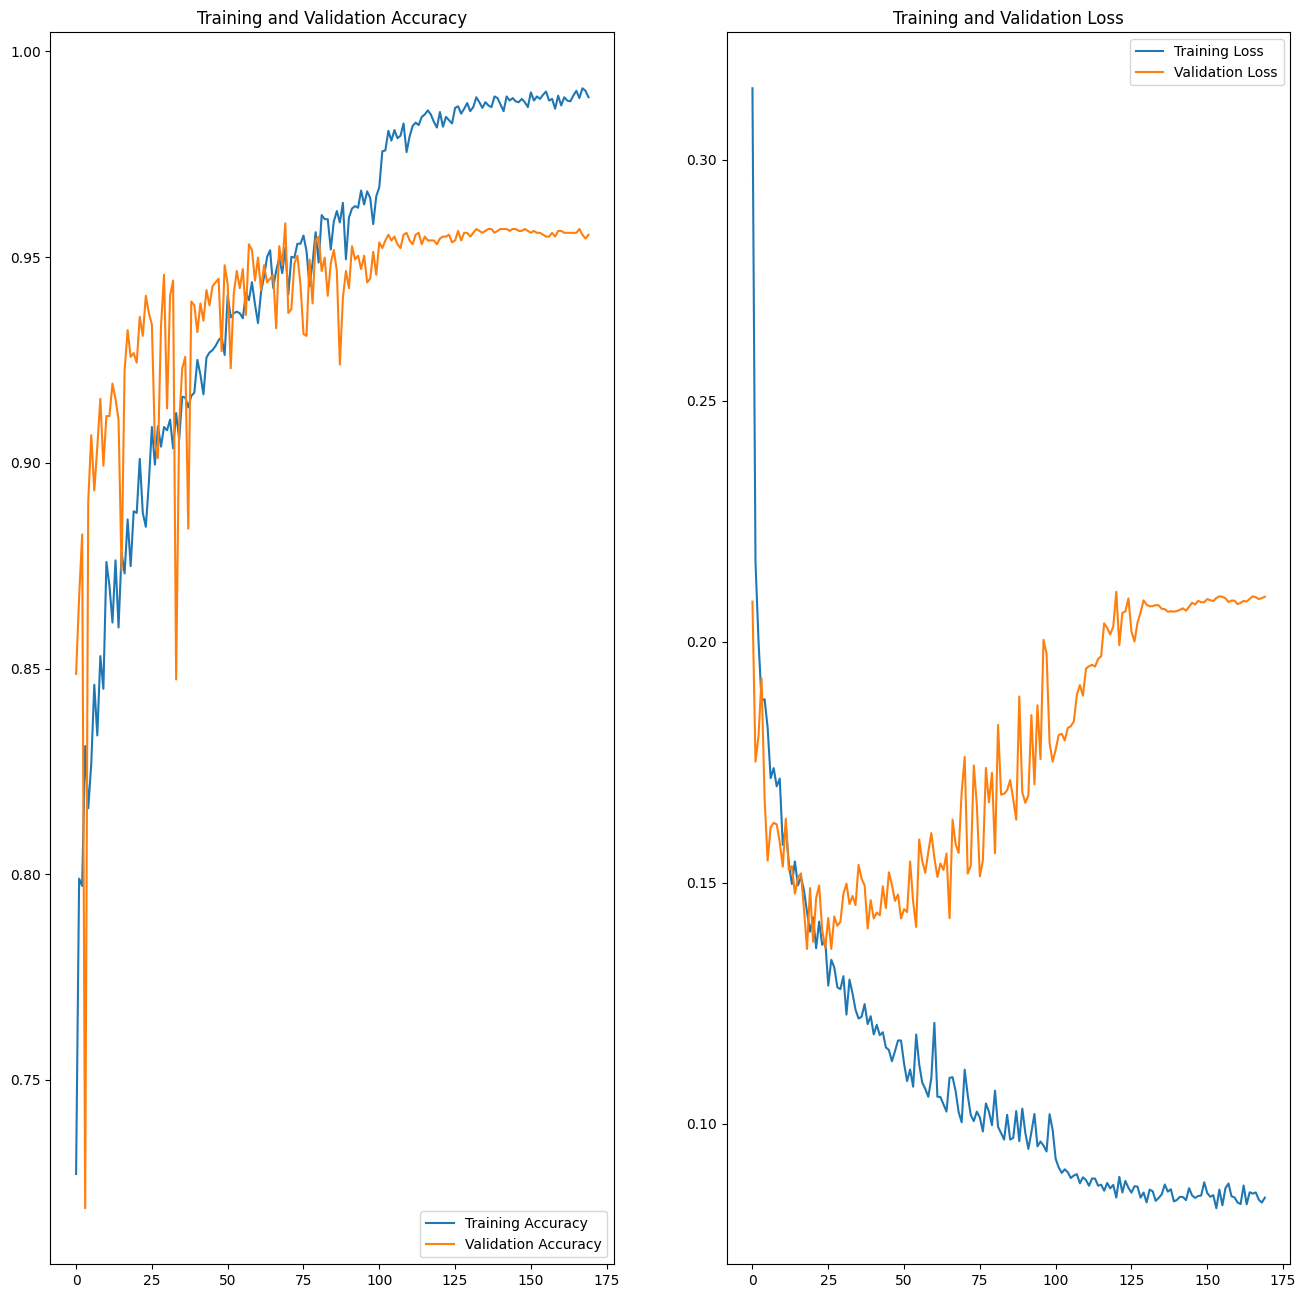

In [15]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


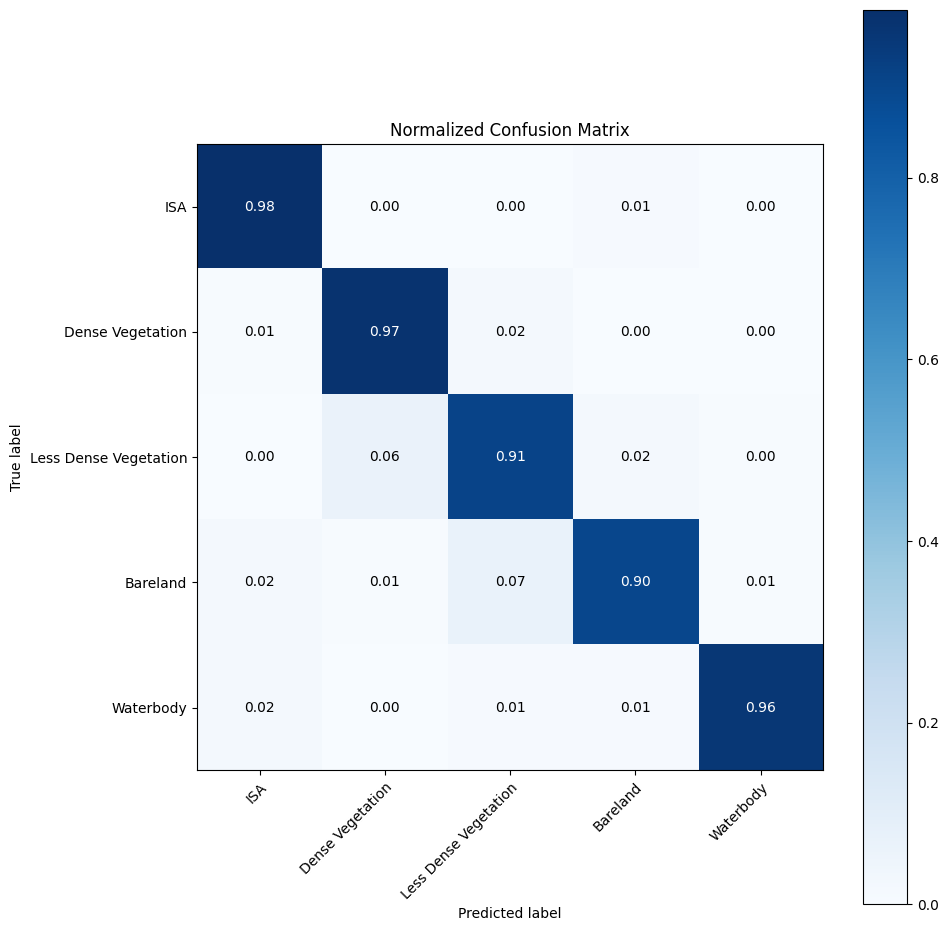

In [16]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Dense Vegetation','Less Dense Vegetation', 'Bareland', 'Waterbody']

y_pred = model.predict([X_test, mask_test])
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()

In [17]:
def permutation_importance_predict(model, X_test, mask_test, y_test, feature_names, n_repeats=5):
    X_test = np.array(X_test, dtype=np.float32)
    
    # Debug: Check shapes
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    # Get baseline predictions
    baseline_pred = model.predict([X_test, mask_test], verbose=0)
    print(f"baseline_pred shape: {baseline_pred.shape}")
    
    # Handle different y_test formats
    if len(y_test.shape) == 1:
        # If y_test is 1D (class indices), use it directly
        y_true_classes = y_test
    else:
        # If y_test is one-hot encoded, convert to class indices
        y_true_classes = np.argmax(y_test, axis=1)
    
    # Convert predictions to class indices
    baseline_pred_classes = np.argmax(baseline_pred, axis=1)
    
    baseline_acc = np.mean(baseline_pred_classes == y_true_classes)
    print(f"Baseline accuracy: {baseline_acc:.4f}")
    
    importance_scores = {}
    
    for i, feature_name in enumerate(feature_names):
        print(f"Computing importance for {feature_name}...")
        
        scores = []
        for repeat in range(n_repeats):
            X_test_perm = np.copy(X_test).astype(np.float32)
            
            # Permute feature i across all time steps
            for t in range(X_test.shape[1]):
                np.random.shuffle(X_test_perm[:, t, i])
            
            # Use predict instead of evaluate
            perm_pred = model.predict([X_test_perm, mask_test], verbose=0)
            perm_pred_classes = np.argmax(perm_pred, axis=1)
            perm_acc = np.mean(perm_pred_classes == y_true_classes)
            importance_drop = baseline_acc - perm_acc
            scores.append(importance_drop)
        
        importance_scores[feature_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'scores': scores
        }
        
        print(f"{feature_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    return importance_scores

In [18]:
def plot_feature_importance(importance_scores):
    import matplotlib.pyplot as plt
    
    features = list(importance_scores.keys())
    means = [importance_scores[f]['mean'] for f in features]
    stds = [importance_scores[f]['std'] for f in features]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(features, means, yerr=stds, capsize=5, alpha=0.7)
    plt.ylabel('Importance Score (Accuracy Drop)')
    plt.title('Feature Importance (Permutation-based)')
    plt.xticks(rotation=0)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{mean:.3f}', ha='center', va='bottom')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

X_test shape: (2155, 24, 6)
y_test shape: (2155,)
baseline_pred shape: (2155, 5)
Baseline accuracy: 0.9582
Computing importance for NDVI...
NDVI: 0.1550 ± 0.0044
Computing importance for MNDWI...
MNDWI: 0.2528 ± 0.0048
Computing importance for NDBI...
NDBI: 0.0295 ± 0.0028
Computing importance for NDBSI...
NDBSI: 0.0509 ± 0.0045
Computing importance for CBI...
CBI: 0.4557 ± 0.0054
Computing importance for UCI...
UCI: 0.2271 ± 0.0031


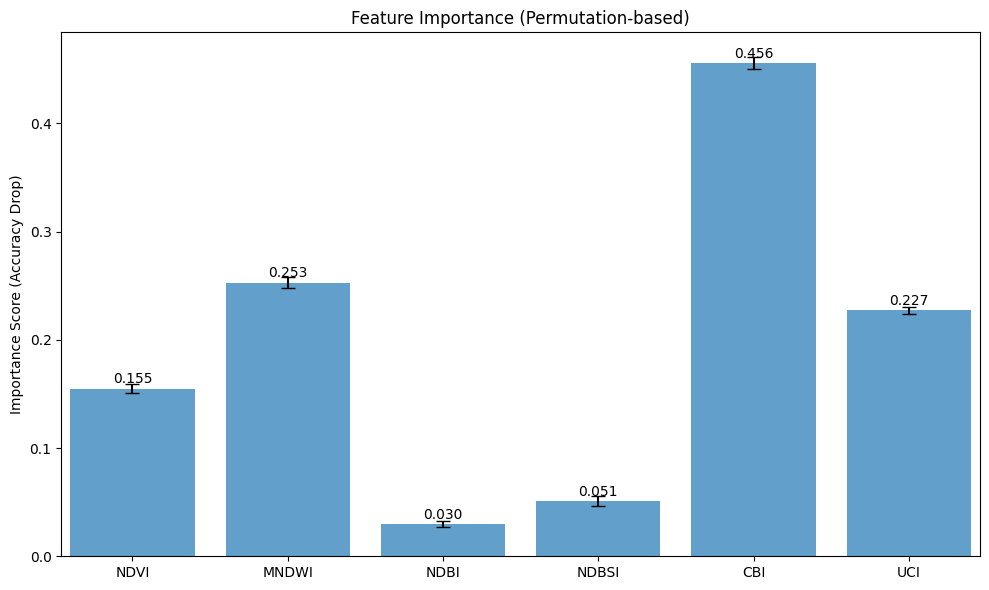


Feature Importance Ranking:
1. CBI: 0.4557 ± 0.0054
2. MNDWI: 0.2528 ± 0.0048
3. UCI: 0.2271 ± 0.0031
4. NDVI: 0.1550 ± 0.0044
5. NDBSI: 0.0509 ± 0.0045
6. NDBI: 0.0295 ± 0.0028


In [19]:
feature_names = ['NDVI', 'MNDWI', 'NDBI', 'NDBSI', 'CBI', 'UCI']
importance_results = permutation_importance_predict(model, X_test, mask_test, y_test, feature_names, n_repeats=5)

plot_feature_importance(importance_results)
sorted_features = sorted(importance_results.items(), key=lambda x: x[1]['mean'], reverse=True)
print("\nFeature Importance Ranking:")
for i, (feature, scores) in enumerate(sorted_features, 1):
    print(f"{i}. {feature}: {scores['mean']:.4f} ± {scores['std']:.4f}")